# Task 1: Pacific Tide Gauge Data

---

This is Matt Pudig's notebook for MATH5271 class portfolio task 1. 

In this notebook, we load and analyse one year of hourly data from the _Pacific Sea Level Monitoring Project_ for the Pacific island nation, Tonga.

_"This task should include at least 3 original figures and approximately 1000 words of text. Your draft should include a solid attempt at parts 1 and 2 and at least a proposed outline of part 3. (The closer your draft is to complete the more useful your peer feedback will be)."_

---

In [1371]:
# Import libraries

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

Section 1.1
---
1.1 _"Download one year of hourly data for one location for the Pacific Sea Level Monitoring Project (http://www.bom.gov.au/oceanography/projects/spslcmp/data/index.shtml) and load these data into a platform such as Google Colaboratory. Briefly describe the source of these data (instruments, procedure, purpose etc) and display/describe the data graphically with one quality figure."_

---

In [1372]:
# Load in the csv file from my public github repository: https://github.com/mpudig/MATH5271/tree/main/ClassPortfolio/Task1

tonja_url = 'https://raw.githubusercontent.com/mpudig/MATH5271/main/ClassPortfolio/Task1/tonga.csv'
df = pd.read_csv(tonja_url)

# Examine first 5 rows
df.head()

,Date & UTC Time,Sea Level,Water Temperature,Air Temperature,Barometric Pressure,Residuals,Adjusted Residuals,Wind Direction,Wind Gust,Wind Speed,Tonga
0,01-Jan-2020 00:00,1.556,26.6,26.9,1005.2,0.016,-0.062,185,15.1,7.4,NaN
1,01-Jan-2020 01:00,1.430,26.6,26.9,1005.4,0.019,-0.061,183,15.2,8.8,NaN
2,01-Jan-2020 02:00,1.240,26.6,26.2,1005.4,0.019,-0.058,167,15.8,8.0,NaN
3,01-Jan-2020 03:00,1.038,26.6,26.4,1004.9,0.018,-0.060,192,13.5,7.2,NaN
4,01-Jan-2020 04:00,0.877,26.5,25.9,1005.0,0.018,-0.065,182,13.5,7.8,NaN


---

The data to be used in this notebook are sourced from Australia Bureau of Meteorology's _Pacific Sea Level Monitoring Project_ (http://www.bom.gov.au/oceanography/projects/spslcmp/data/index.shtml). blah... blah blah ...

http://www.bom.gov.au/ntc/IDO50000/IDO50000_67070.pdf

http://www.bom.gov.au/oceanography/projects/spslcmp/data/data.shtml

---

Section 1.2
---
1.2 _"Investigate these data using frequency domain analysis techniques. For example, fit a discrete number of harmonics to the air and water temperature data and compute the spectral density of the sea-level data. Explain the maths underpinning this analysis and explicitly code at least some of the diagnostics (e.g. write a code to determine Fourier coefficients)."_

---

In [1417]:
# Convert the pandas dataframe to an xarray dataset for ease (i.e., I know how to use the latter better)

def convert_to_xr_dataset(pd_dataframe):
    # Make into xarray dataset
    ds = pd_dataframe.to_xarray() 
    # Remove the old, useless coordinate
    ds = ds.drop_vars('index')
    ds['index'] = np.linspace(2020, 2021, ds.index.size)
    # Rename coordinate
    ds = ds.rename({'index': 'time'})

    return ds

ds = convert_to_xr_dataset(df)

temp_air = ds['Air Temperature']
temp_water = ds['Water Temperature']
sea_level = ds['Sea Level']

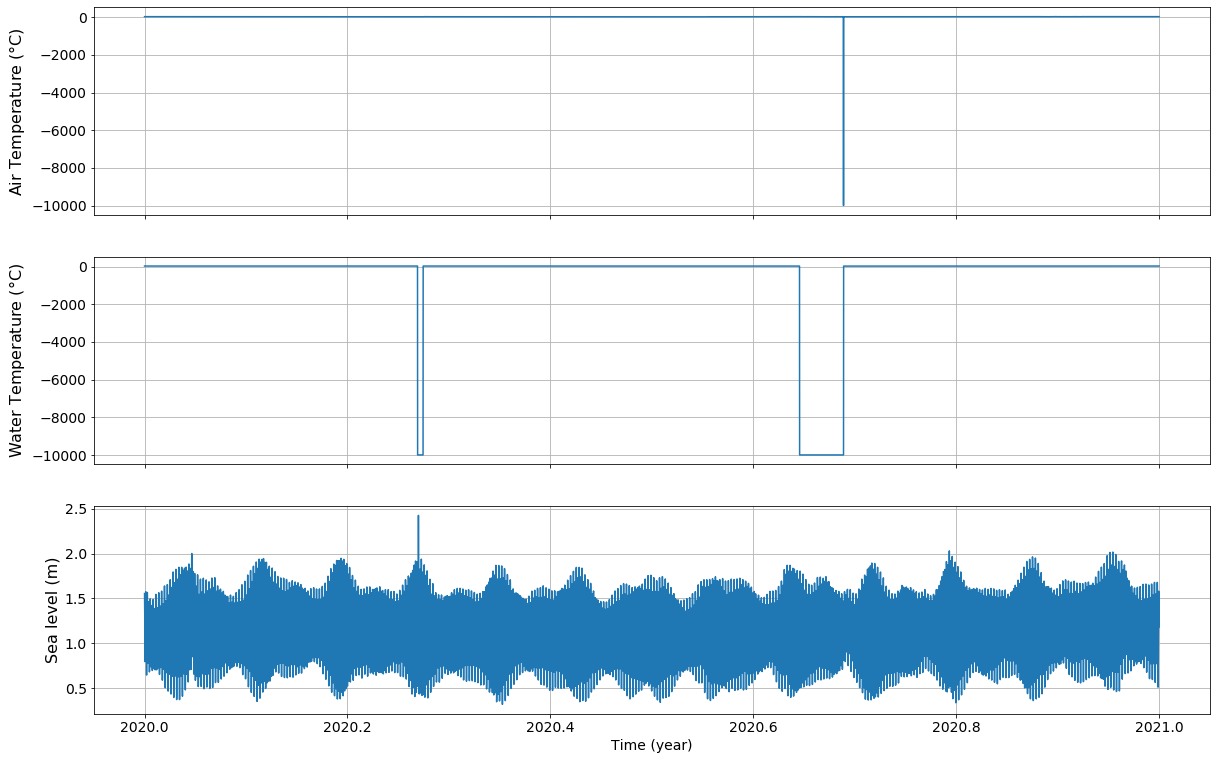

In [1418]:
# Plot for exploratory DA

fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(20,13), sharex=True)
ax = axs[0]
temp_air.plot(ax=ax), ax.grid(), ax.set_xlabel(''), ax.set_ylabel('Air Temperature ($\degree$C)', fontsize=16), ax.tick_params(labelsize=14)

ax = axs[1]
temp_water.plot(ax=ax), ax.grid(), ax.set_xlabel(''), ax.set_ylabel('Water Temperature ($\degree$C)', fontsize=16), ax.tick_params(labelsize=14)

ax = axs[2]
sea_level.plot(ax=ax), ax.grid(), ax.set_xlabel('Time (year)', fontsize=14), ax.set_ylabel('Sea level (m)', fontsize=16), ax.tick_params(labelsize=14)

plt.show()

Clearly, there are some error/missing values in the air temp and water temp data, as there are values = -9999. Let's remove these, and also make sure there are no other 'impossible values' (just for completeness!).

Much nicer!


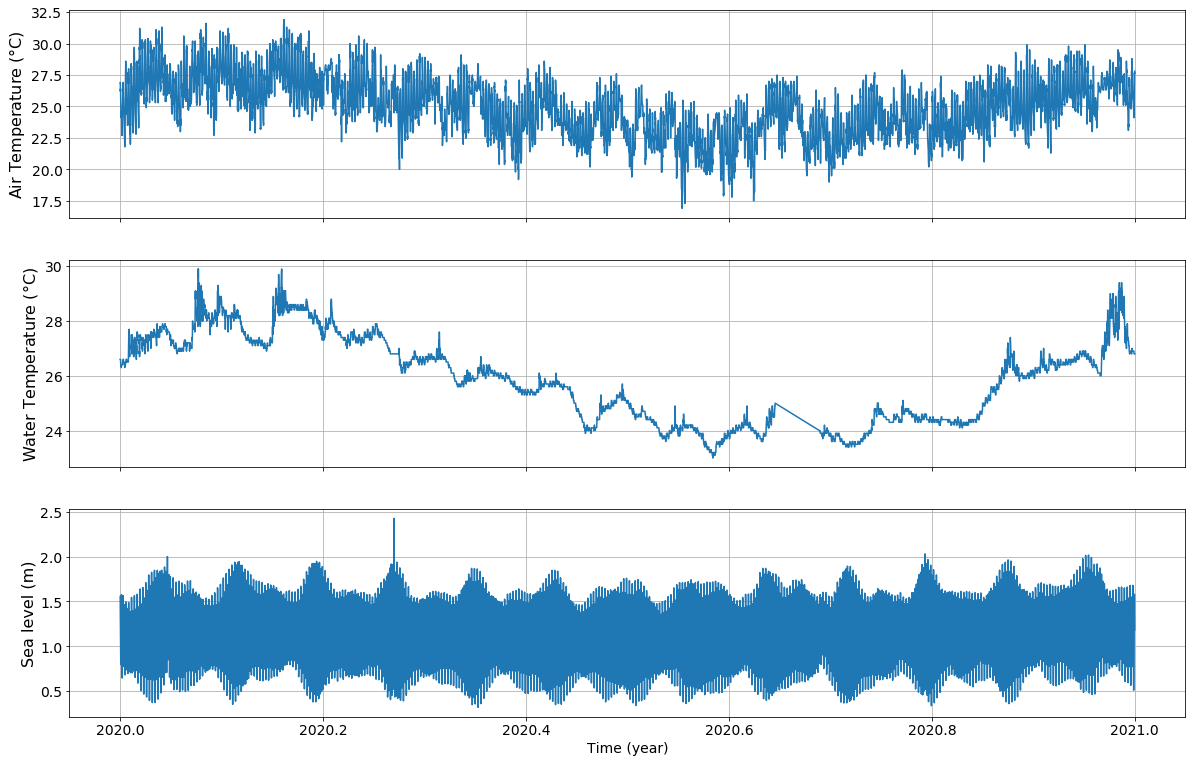

In [1419]:
def remove_impossible_vals(array):
    # Returns array such that all values in array are >= -100 and <= 100
    
    return array[(array >= -100) & (array <= 100)] 

temp_air = remove_impossible_vals(temp_air)
temp_water = remove_impossible_vals(temp_water)
sea_level = remove_impossible_vals(sea_level)

# Plot again

fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(20,13), sharex=True)
ax = axs[0]
temp_air.plot(ax=ax), ax.grid(), ax.set_xlabel(''), ax.set_ylabel('Air Temperature ($\degree$C)', fontsize=16), ax.tick_params(labelsize=14)

ax = axs[1]
temp_water.plot(ax=ax), ax.grid(), ax.set_xlabel(''), ax.set_ylabel('Water Temperature ($\degree$C)', fontsize=16), ax.tick_params(labelsize=14)

ax = axs[2]
sea_level.plot(ax=ax), ax.grid(), ax.set_xlabel('Time (year)', fontsize=14), ax.set_ylabel('Sea level (m)', fontsize=16), ax.tick_params(labelsize=14)

print('Much nicer!')

In [1420]:
# Subtract the mean in order to fit harmonics

temp_air_zeromean = temp_air - np.mean(temp_air)
temp_water_zeromean = temp_water - np.mean(temp_water)
sea_level_zeromean = sea_level - np.mean(sea_level)

---
We first compute the power spectra for air temperature and water temperature to see where the dominant frequencies are.

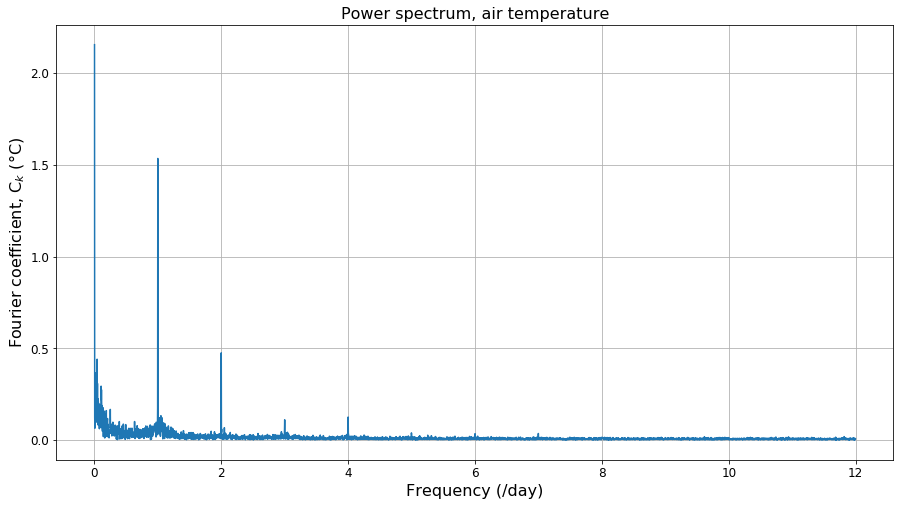

In [1421]:
# Compute the power spectrum of air temp

data = temp_air_zeromean

n = data.size
spec = np.fft.rfft(data, n) / (n / 2)
fourier = abs(spec[1 : int(n / 2)])
R2_k = (n / 2) * fourier**2 / ((n - 1) * np.var(data, ddof=1).values)
freq_days = np.arange(1, int(n / 2)) / (n / 24)

plt.figure(figsize=(15,8))
plt.title('Power spectrum, air temperature', fontsize=16)
plt.plot(freq_days, fourier)
plt.ylabel('Fourier coefficient, C$_k$ ($\degree$C)', fontsize=16)
# plt.plot(freq_days, R2_k)
# plt.ylabel('Normalised spectral density, R$^2_k$', fontsize=16)
plt.xlabel('Frequency (/day)', fontsize = 16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.grid()
plt.show()

---
Most of the power in the air temperature data is located at yearly and daily periods. This is confirmed by the spikes in its power spectrum at frequencies 0.00273(day)$^{-1}$ and 1.00011(day)$^{-1}$, which in terms of periods (reciprocal of frequencies) correspond to 365.96 days and 1.0 day, respectively. (Note that the yearly period is almost 366 days since 2020 was a leap year.)

There is also some power at the frequency 2.00022day$^{-1}$ (i.e., approximately a period of 12 hours). I am yet to figure out whether this is an aliased lower frequency, or a 'real' signal.

For now, though, we will fit two harmonics corresponding to the daily and yearly periods.

---

_Maths on fitting the Fourier coefficients:_

In [1422]:
# Explicitly calculate (using summation formulae) the Fourier coefficients corresponding to daily and yearly periods

def cos_func(k):
    return np.cos(2 * np.pi * k * np.arange(0, n) / n)

def sin_func(k):
    return np.sin(2 * np.pi * k * np.arange(0, n) / n)

def fourier_coefficient(data, k):
    # k = Fourier harmonic
    
    n = data.shape[0]
    A_k = (2 / n) * np.sum(data.values * cos_func(k))
    B_k =(2 / n) * np.sum(data.values * sin_func(k))
    
    return (A_k, B_k)

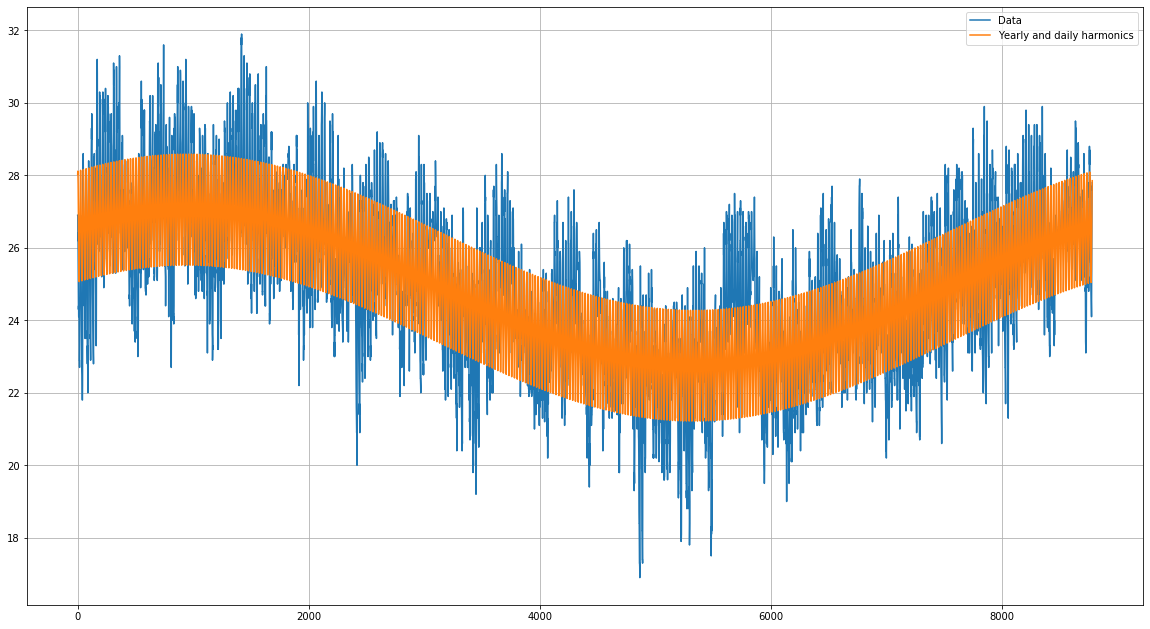

In [1423]:
A_1, B_1 = fourier_coefficient(data, 1) # Yearly harmonic Fourier coefficients
A_366, B_366 = fourier_coefficient(data, 366) # Daily harmonic Fourier coefficients

plt.figure(figsize=(20,11))

temp_air_fit = np.mean(temp_air).values + A_1 * cos_func(1) + B_1 * sin_func(1) + A_366 * cos_func(366) + B_366 * sin_func(366)
plt.plot(temp_air, label='Data')
plt.plot(temp_air_fit, label='Yearly and daily harmonics')

plt.grid()
plt.legend()

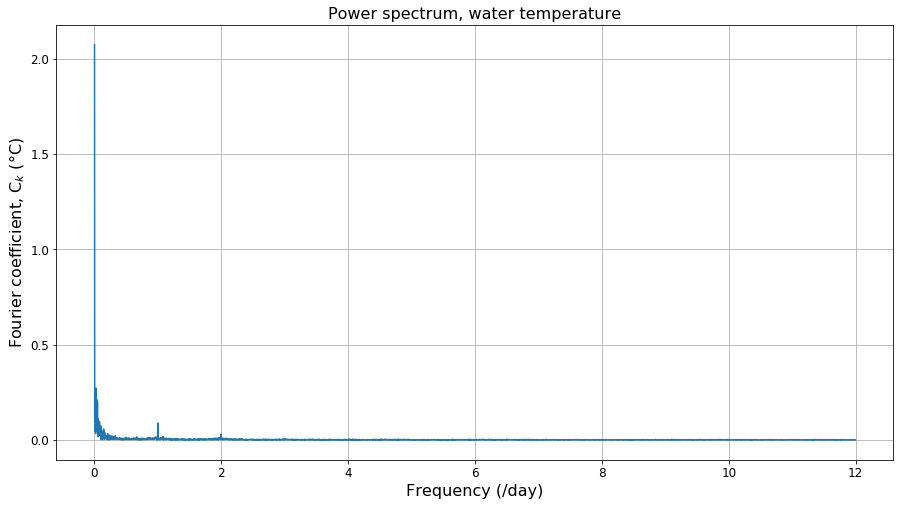

In [1424]:
# Compute the power spectrum of air temp

data = temp_water_zeromean

n = data.size
spec = np.fft.rfft(data, n) / (n / 2)
fourier = abs(spec[1 : int(n / 2)])
R2_k = (n / 2) * fourier**2 / ((n - 1) * np.var(data, ddof=1).values)
freq_days = np.arange(1, int(n / 2)) / (n / 24)

plt.figure(figsize=(15,8))
plt.title('Power spectrum, water temperature', fontsize=16)
plt.plot(freq_days, fourier)
plt.ylabel('Fourier coefficient, C$_k$ ($\degree$C)', fontsize=16)
# plt.plot(freq_days, R2_k)
# plt.ylabel('Normalised spectral density, R$^2_k$', fontsize=16)
plt.xlabel('Frequency (/day)', fontsize = 16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.grid()
plt.show()

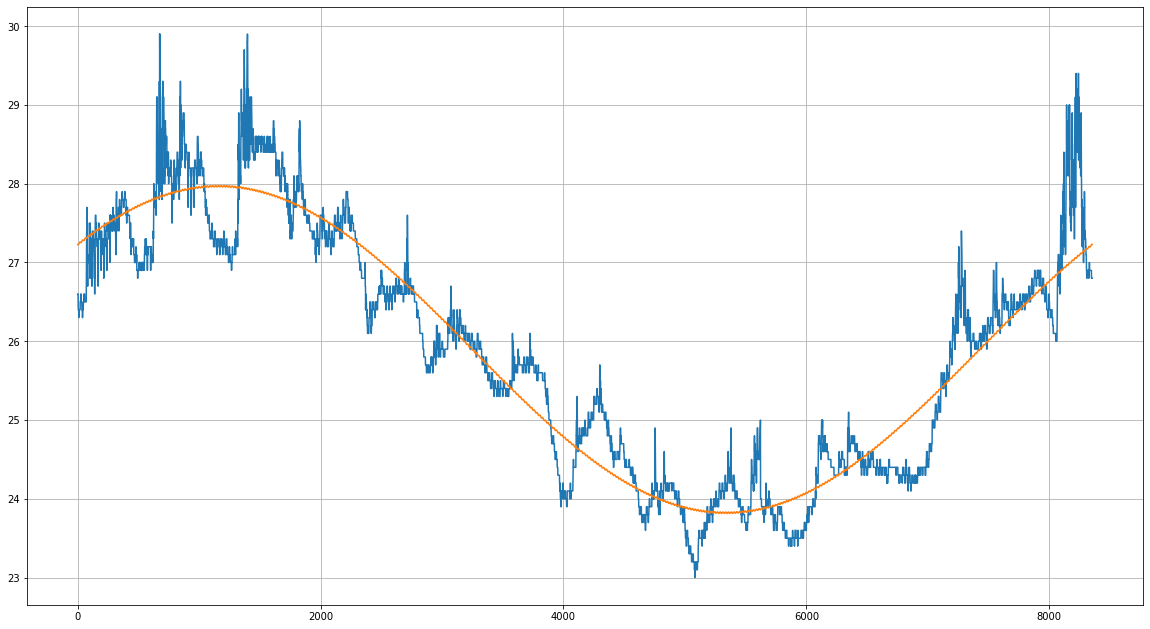

In [1425]:
A_1, B_1 = fourier_coefficient(data, 1) # Yearly harmonic Fourier coefficients
A_366, B_366 = fourier_coefficient(data, 366) # Daily harmonic Fourier coefficients

plt.figure(figsize=(20,11))

temp_water_fit = np.mean(temp_water).values + A_1 * cos_func(1) + B_1 * sin_func(1) \
+ A_366 * cos_func(366) + B_366 * sin_func(366)
plt.plot(temp_water)
plt.plot(temp_water_fit)

plt.grid()

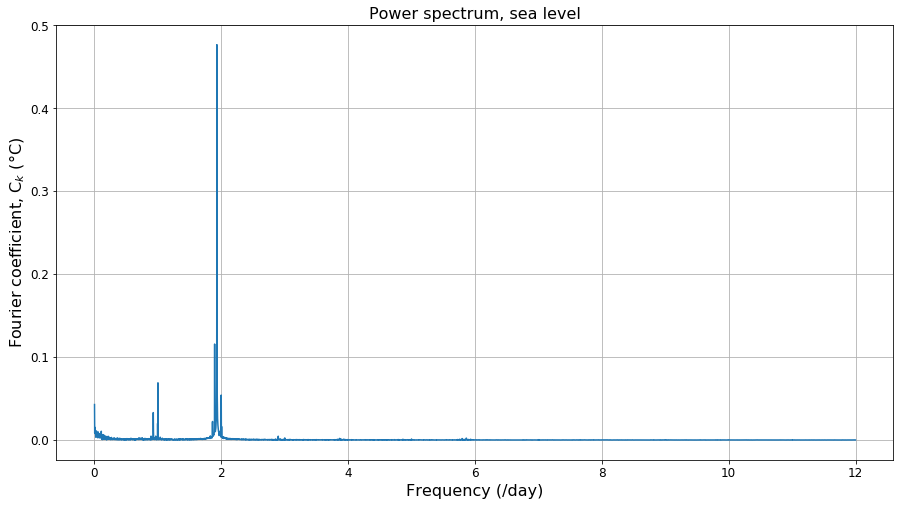

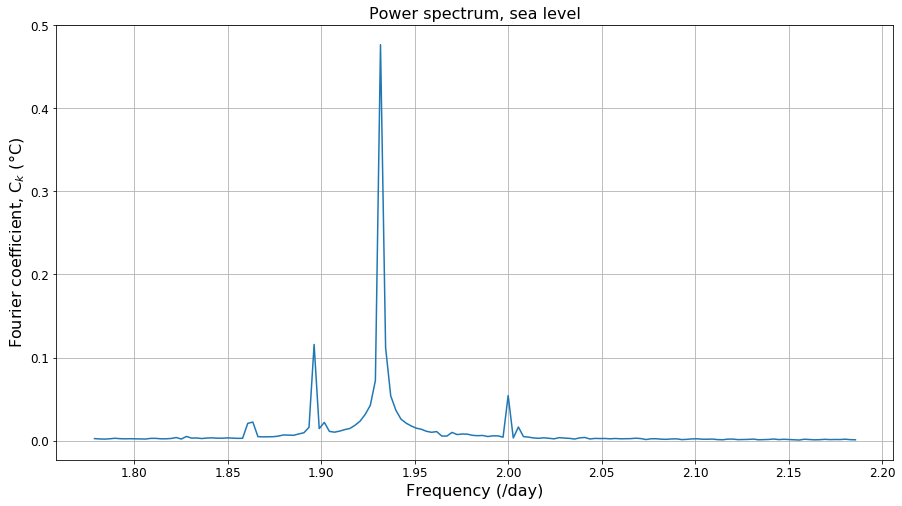

In [1452]:
# Compute the power spectrum of the sea level data

data = sea_level_zeromean

n = data.size
spec = np.fft.rfft(data, n) / (n / 2)

R2_k = (n / 2) * abs(spec[1 : int(n / 2)])**2 / ((n - 1) * np.var(data, ddof=1).values)

plt.figure(figsize=(15,8))
plt.title('Power spectrum, sea level', fontsize=16)
plt.plot((np.arange(1, int(n / 2)) / (n / 24)), (abs(spec[1 : int(n / 2)])))
plt.ylabel('Fourier coefficient, C$_k$ ($\degree$C)', fontsize=16)
# plt.plot(np.arange(1, int(n / 2)) / (n / 24), R2_k)
# plt.ylabel('Normalised spectral density, R$^2_k$', fontsize=16)
plt.xlabel('Frequency (/day)', fontsize = 16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.grid()
plt.show()

plt.figure(figsize=(15,8))
plt.title('Power spectrum, sea level', fontsize=16)
plt.plot((np.arange(1, int(n / 2)) / (n / 24))[650:800], (abs(spec[1 : int(n / 2)]))[650:800])
plt.ylabel('Fourier coefficient, C$_k$ ($\degree$C)', fontsize=16)
# plt.plot(np.arange(1, int(n / 2)) / (n / 24), R2_k)
# plt.ylabel('Normalised spectral density, R$^2_k$', fontsize=16)
plt.xlabel('Frequency (/day)', fontsize = 16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.grid()
plt.show()

In [1463]:
print(f'Thus, the dominant frequency from the spectrum corresponds to a period of \
{int(1/((np.arange(1, int(n / 2)) / (n/24))[np.argmax(abs(spec[1 : int(n / 2)]))]) * 24)} hrs \
and {np.round((1/((np.arange(1, int(n / 2)) / (n/24))[np.argmax(abs(spec[1 : int(n / 2)]))]) * 24 - 12)*60,2)} mins.')


Thus, the dominant frequency from the spectrum corresponds to a period of 12 hrs and 25.46 mins.


Section 1.3
---
1.3 _"Interpret these analyses in terms of putative physical processes such as the seasonal cycle and the tides. Discuss what aspects of the results are real physical signals and which could indicate aliasing or similar issues related to the data set."_

---

https://en.wikipedia.org/wiki/Tide

https://en.wikipedia.org/wiki/Theory_of_tides

Marine heatwaves

Poor resolution in water temp data